# Problema de regresión

## Descripción del problema

En este problema vamos a trabajar con el conjunto de datos _Airfoil Self-Noise_, el cuál ha sido proporcionado por la NASA, y contiene los resultados de haber realizado un conjunto de pruebas aerodinámicas y acústicas en un túnel de viento sobre perfiles alares de dos y tres dimensiones.

El conjunto de datos está compuesto por 1503 filas y 6 columnas, los valores de las cuáles son todos números reales. Los datos de las 5 primeras columnas se corresponden con los datos de entrada, y la última columna se corresponde con la información de salida. A continuación se puede ver que representa cada uno de los atributos de forma ordenada:

1. Frecuencia, medida en $Hz$.
2. Ángulo de ataque (ángulo que forman la cuerda geométrica de un perfil alar con la dirección del aire incidente), medida en grados.
3. Longitud de la cuerda del perfil alar, medida en metros.
4. Velocidad _free-stream_, medida en metros por segundo. 
5. Distancia de desplazamiento de succión, medida en metros.
6. Nivel de presión sonora, medida en $dB$.

## Análisis y preprocedado de los datos

Antes de comenzar con todo el proceso de elección y selección de un modelo lineal, vamos a pararnos un momento para analizar los datos de los que disponemos con el fin de obtener más información sobre el problema.

Lo primero que tenemos que hacer es cargar los datos. Para ello, vamos a usar una función genérica que nos permita leer ficheros de datos y obtener un _DataFrame_ que podamos usar luego. Vamos a ver como sería esta función:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Establecer la semilla que vamos a utilizar
np.random.seed(1)

def read_data_values(in_file, separator=None):
    """
    Funcion para leer los datos de un archivo
    
    :param in_file Archivo de entrada
    :param separator Separador que se utiliza en el archivo (por defecto
                     None)
    
    :return Devuelve los datos leidos del archivo en un DataFrame
    """
    
    # Cargar los datos en un DataFrame
    # Se indica que la primera columna no es el header
    df = pd.read_csv(in_file, sep=separator, header=None)
    
    return df

Con la función ya mostrada, vamos a cargar los datos y mostrar los primeros valores de la muestra, para tener una idea de como serán los datos:

In [2]:
df = read_data_values('datos/airfoil_self_noise.dat', separator='\t')

# Asignamos nombres a las columnas (según los atributos)
column_names = ['Frequency', 'Angle of attack', 'Chord length',
                'Free-stream velocity', 'SSD thickness', 'Sound Pressure']
df.columns = column_names

# Mostrar primeros valores de los datos
df.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


Antes de proseguir, vamos a dividir los datos en los conjuntos de training y test. Para esto, vamos a crear una función que nos permita dividir los datos en los datos de entrada y los datos de salida (etiquetas), para poder posteriormente dividirlos en los dos conjuntos. Vamos a hacer que ell 80% de los datos se quede en training, y que el 20% de los datos esté en test.

Con esto dicho, vamos a ver como ser haría:

In [3]:
# Función para dividir los datos en train y test
from sklearn.model_selection import train_test_split

def divide_data_labels(input_data):
    """
    Funcion que divide una muestra en los datos y las etiquetas
    
    :param input_data Conjunto de valores que se quieren separar
                      juntados en un DataFrame
    
    :return Devuelve los datos y las etiquetas
    """
    
    #Obtener los valores
    values = input_data.values
    
    # Obtener datos y etiquetas
    X = values[:, :-1]
    y = values[:, -1]
    
    return X, y

# Obtener valores X, Y
X, y = divide_data_labels(df)

# Dividir los datos en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.2, random_state=1, shuffle=True)

Con los datos ya cargados y divididos en los conjuntos de training y test, vamos a obtener cierta información
sobre éstos. En problemas de este tipo nos interesa conocer por ejemplo si en ciertos casos faltan datos (no se ha podido obtener información sobre todos los atributos debido a que es imposible hacerlo, han habido errores a la hora de tomarlos o no se disponía de las herramientas necesarias), el número de valores distintos, los rangos de los datos (valores mínimos y máximos para cada atributo), si existe algún tipo de correlación entre las variables, etc.

Vamos a comenzar estudiando primero las características más simples, para adentrarnos luego en el estudio de la correlación. Empecemos mirando información del conjunto training:

In [4]:
# Clase para mostrar información de DataFrames resumida
from pandas_summary import DataFrameSummary
from IPython.core.display import display

# Crear información resumida sobre los datos de training
train_df = pd.DataFrame(columns=column_names,
                        data=np.c_[X_train, y_train])
train_sum = DataFrameSummary(train_df).summary()
display(train_sum)

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
count,1202,1202,1202,1202,1202,1202
mean,2966.26,6.73569,0.136403,50.941,0.0111494,124.852
std,3246.55,5.9433,0.0934083,15.605,0.0132485,6.9909
min,200,0,0.0254,31.7,0.000400682,103.38
25%,800,2,0.0508,39.6,0.00251435,120.1
50%,2000,5.3,0.1016,39.6,0.00495741,125.821
75%,4000,10.875,0.2286,71.3,0.0150478,130.071
max,20000,22.2,0.3048,71.3,0.0584113,140.987
counts,1202,1202,1202,1202,1202,1202
uniques,21,27,6,4,105,1169


Aquí podemos ver que para ninguno de los atributos faltan datos, lo cuál nos ahorra tiempo extra de procesado en el que tendríamos que insertar valores a partir de algún valor estadístico (valores medios, por ejemplo).

También podemos ver información sobre como varían los datos, tanto los de entrada como los de salida. Vemos que, por ejemplo, la frecuencia es un atributo que varía mucho, ya que tiene unos valores mínimos y máximos muy dispares, además de tener una desviación típica muy elevada. Posiblemente este atributo contenga _outliers_, pero al no disponer de demasiados datos, y al ser tan pocos los posibles valores anómalos, no merece la pena intentar eliminarlos. Mirando el resto de datos de entrada, nos encontramos con unos valores que varían menos y que tienen un rango de valores más pequeño. Lo sorprendente es que, para los datos de entrada, tenemos que hay muy pocos valores únicos (no repetidos). Esto se puede deber a que no se han medido los valores con suficiente precisión o a que no exista una verdadera variabilidad entre ellos. Para los datos de salida, en cambio, nos encontramos que hay un montón de valores distintos. Esto es normal, ya que, al ser valores reales, hay muchos posibles valores. De aquí podemos concluir que, a pesar de que nos encontremos ante un problema con variable reales, parece que los
valores que toman las variables de entrada están discretizados, es decir, que no son exactamente contínuos.

Pasemos ahora a analizar el conjunto de datos de entrenamiento. Para obtener suficiente información, vamos a fijarnos solo en valores únicos y si faltan datos, teniendo en cuenta que nunca debemos obtener información completa sobre estos, ya que se supone que nunca serán conocidos. A continuación, podemos ver esta información:

In [7]:
test_df = pd.DataFrame(columns=column_names,
                       data=np.c_[X_test, y_test])
test_sum = DataFrameSummary(test_df).columns_stats
display(test_sum)

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
counts,301,301,301,301,301,301
uniques,20,27,6,4,97,300
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%
types,numeric,numeric,numeric,numeric,numeric,numeric


Como se puede ver, el número de valores únicos, para las variables de entrada, son muy próximos a los que teníamos anteriormente. En el caso de los valores de salida, podemos observar que hay mucha diversidad. Y, finalmente, como punto positivo, podemos ver que en ninguna de las muestras faltan datos.

Una vez hecho este pequeño análisis, pasemos a observar ahora la correlación entre las variables. Vamos a intentar obtener, para cada una de las variables (tanto las de entrada como las de salida) el coeficiente de correlación de Pearson. El resultado se puede ver a continuación:

In [14]:
# Obtener gráfica de correlación de Pearson
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Frequency,Angle of attack,Chord length,Free-stream velocity,SSD thickness,Sound Pressure
Frequency,1,-0.270796,-0.018266,0.122803,-0.233431,-0.395423
Angle of attack,-0.270796,1,-0.498267,0.0703666,0.754145,-0.159278
Chord length,-0.018266,-0.498267,1,-0.0241411,-0.22103,-0.23498
Free-stream velocity,0.122803,0.0703666,-0.0241411,1,-0.00863181,0.13866
SSD thickness,-0.233431,0.754145,-0.22103,-0.00863181,1,-0.314796
Sound Pressure,-0.395423,-0.159278,-0.23498,0.13866,-0.314796,1


Se puede ver que, en general, la mayoría de variables no están relacionadas entre ellas. Sin embargo, sí que destacan dos casos, uno más que el otro. El primer caso es la relación que existe entre la característica **SSD thickness** y la característica **Angle of attack**. Estas dos características tienen una coeficiente de correlación de Pearson de 0.75, valor que es muy próximo a 1. Por tanto, existe cierta correlación entre ellas, ya que el crecimiento de una influirá en el crecimiento de la otra.

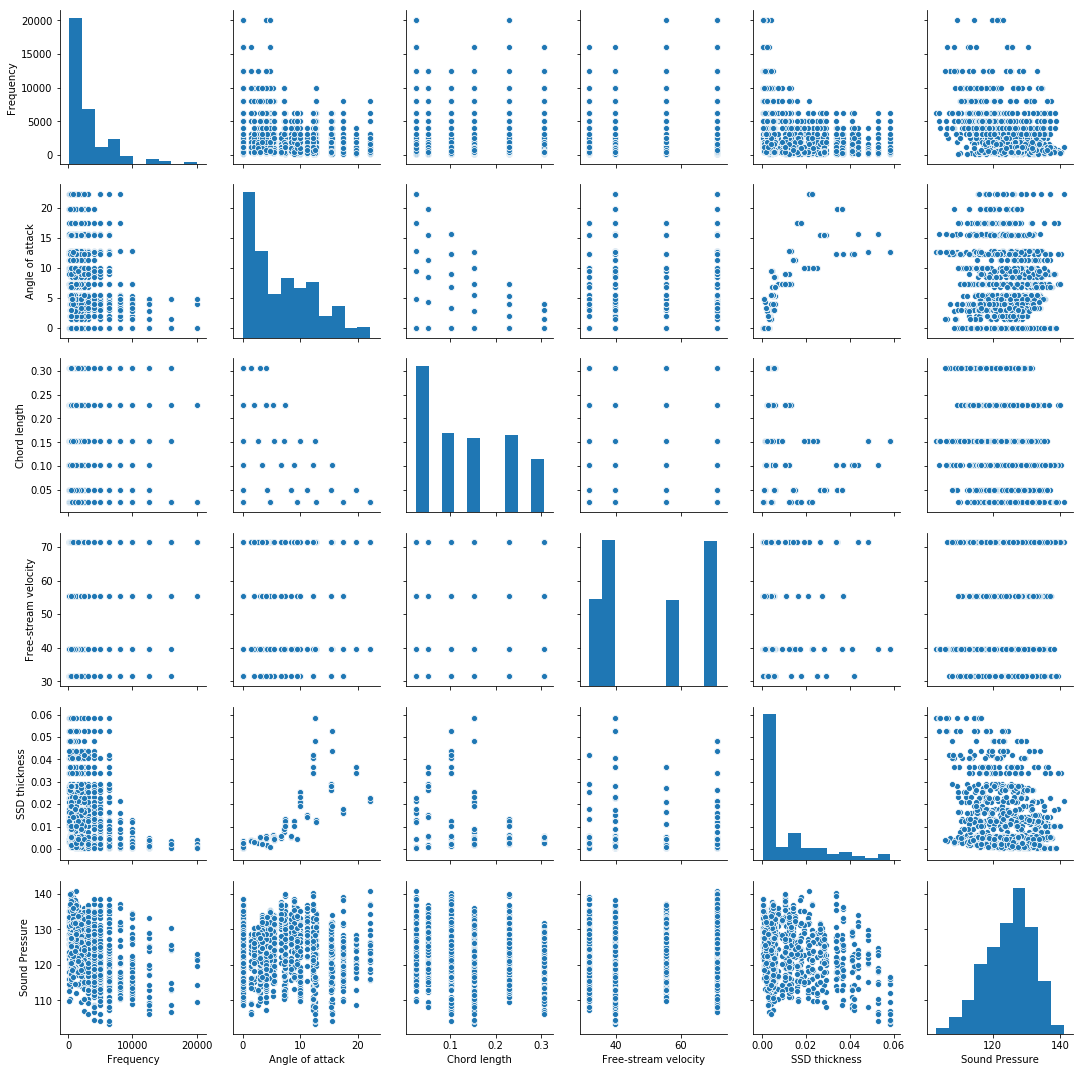

In [16]:
import seaborn as sns
sns.pairplot(train_df)
plt.show()

Escoger nuestros modelos.